### Import Libraries

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import os

outdir = r'./eval/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
outdir = r'./eval/stacked'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [2]:
random_state = 23873

dt = pd.read_excel(r'./data/CA_BC.xlsx').T
dt.columns = dt.iloc[0]
dt = dt.iloc[1:]
dt['Label'] = dt.Label.map({'E':1,'A':0})

dt.drop_duplicates(keep='first',inplace=True)


unknown_counter = 1
new_columns = []

for column_name in dt.columns:
    if not column_name or pd.isnull(column_name):
        # Assign "unknown" followed by a number as the column name
        new_columns.append(f"unknown_{unknown_counter}")
        unknown_counter += 1
    else:
        new_columns.append(column_name)

# Update the column names in the DataFrame
dt.columns = new_columns

for x in dt.select_dtypes(include=['object']).columns:
    dt[x] = dt[x].astype('float64')
dt.columns = [str(x) for x in dt.columns]
dt = dt.select_dtypes(include=['float64','int64'])


## Handle Duplicate Columns

# Columns to not rename
excluded = dt.columns[~dt.columns.duplicated(keep=False)]

# An incrementer
import itertools
inc = itertools.count().__next__

# A renamer
def ren(name):
    return f"{name}{inc()}" if name not in excluded else name

# Use inside rename()
for x in range(0,2):
    dt.rename(columns=ren,inplace=True)

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming your data is in a pandas DataFrame called 'dt'
X = dt.drop('Label', axis=1)
y = dt['Label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stacked Generalization (Stacking) with Diverse Base Classifiers
estimators = [
    ('log_reg', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)),
    ('svm', SVC(kernel='linear', class_weight='balanced', random_state=42, probability=True)),
    ('random_forest', RandomForestClassifier(class_weight='balanced', random_state=42))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced', random_state=42), cv=5, n_jobs=-1)
stacking_clf.fit(X_scaled, y)

# Get feature importances from random forest base classifier
rf_clf = stacking_clf.named_estimators_['random_forest']
rf_feature_importances = rf_clf.feature_importances_

# Sort the features by importance
sorted_features_idx = np.argsort(rf_feature_importances)[::-1]

# Initialize performance metrics lists
f1_scores = []
recall_scores = []
accuracy_scores = []

# Iterate over the sorted features and add them in batches of 100
for i in range(1, len(sorted_features_idx) + 1, 100):
    print(i)
    selected_features = sorted_features_idx[:i]
    X_selected = X_scaled[:, selected_features]
    
    # Evaluate the performance using cross-validation
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='f1_macro')
    f1_scores.append(np.mean(scores))
    
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='recall_macro')
    recall_scores.append(np.mean(scores))
    
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

# Add the last remaining features if the number of features is not divisible by 100
if len(sorted_features_idx) % 100 != 0:
    selected_features = sorted_features_idx
    X_selected = X_scaled[:, selected_features]

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='f1_macro')
    f1_scores.append(np.mean(scores))

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='recall_macro')
    recall_scores.append(np.mean(scores))

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901
6001
6101
6201
6301
6401
6501
6601
6701
6801
6901
7001
7101
7201
7301
7401
7501
7601
7701
7801
7901
8001
8101
8201
8301
8401
8501
8601
8701
8801
8901
9001
9101
9201
9301
9401
9501
9601
9701
9801
9901
10001
10101
10201
10301
10401
10501
10601
10701
10801
10901
11001
11101
11201
11301
11401
11501
11601
11701
11801
11901
12001
12101
12201
12301
12401
12501
12601
12701
12801
12901
13001
13101
13201
13301
13401
13501
13601
13701
13801
13901
14001
14101
14201
14301
14401
14501
14601
14701
14801
14901
15001
15101
15201
15301
15401
15501
15601
15701
15801
15901
16001
16101
16201
16301
16401
16501
16601
16701
16801
16901
17001
17101
17201
17301
17401
17501
17601
17701
17801
17901
18001
18101
18201
18301
18401
18

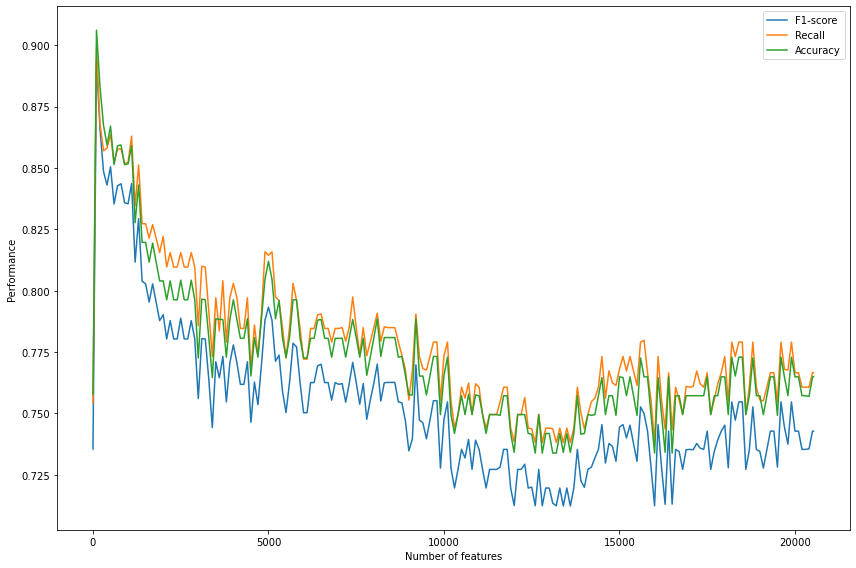

In [4]:
# Calculate the x-axis values
x_values = list(range(1, len(sorted_features_idx) + 1, 100))
if len(sorted_features_idx) % 100 != 0:
    x_values.append(len(sorted_features_idx))

import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(12, 8))

# Plot the performance metrics vs. number of features
plt.plot(x_values, f1_scores, label='F1-score')
plt.plot(x_values, recall_scores, label='Recall')
plt.plot(x_values, accuracy_scores, label='Accuracy')
plt.xlabel('Number of features')
plt.ylabel('Performance')
plt.legend()

# Set a tight layout
plt.tight_layout()

# Save the figure in HD (dpi = 300)
plt.savefig(os.path.join(outdir,"performance_vs_features_stacked.png"), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Get feature names from the DataFrame
feature_names = np.array(X.columns)

# Map the sorted feature indices to their corresponding feature names
sorted_feature_names = feature_names[sorted_features_idx]

In [5]:
# Assuming your data is in a pandas DataFrame called 'dt'
X = dt[sorted_feature_names[:500].tolist() + ['Label']].drop('Label', axis=1)
y = dt['Label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stacked Generalization (Stacking) with Diverse Base Classifiers
estimators = [
    ('log_reg', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)),
    ('svm', SVC(kernel='linear', class_weight='balanced', random_state=42, probability=True)),
    ('random_forest', RandomForestClassifier(class_weight='balanced', random_state=42))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced', random_state=42), cv=5, n_jobs=-1)
stacking_clf.fit(X_scaled, y)

# Get feature importances from random forest base classifier
rf_clf = stacking_clf.named_estimators_['random_forest']
rf_feature_importances = rf_clf.feature_importances_

# Sort the features by importance
sorted_features_idx = np.argsort(rf_feature_importances)[::-1]

# Initialize performance metrics lists
f1_scores = []
recall_scores = []
accuracy_scores = []

# Iterate over the sorted features and add them in batches of 100
for i in range(1, len(sorted_features_idx) + 1, 10):
    print(i)
    selected_features = sorted_features_idx[:i]
    X_selected = X_scaled[:, selected_features]
    
    # Evaluate the performance using cross-validation
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='f1_macro')
    f1_scores.append(np.mean(scores))
    
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='recall_macro')
    recall_scores.append(np.mean(scores))
    
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

# Add the last remaining features if the number of features is not divisible by 100
if len(sorted_features_idx) % 10 != 0:
    selected_features = sorted_features_idx
    X_selected = X_scaled[:, selected_features]

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='f1_macro')
    f1_scores.append(np.mean(scores))

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='recall_macro')
    recall_scores.append(np.mean(scores))

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491


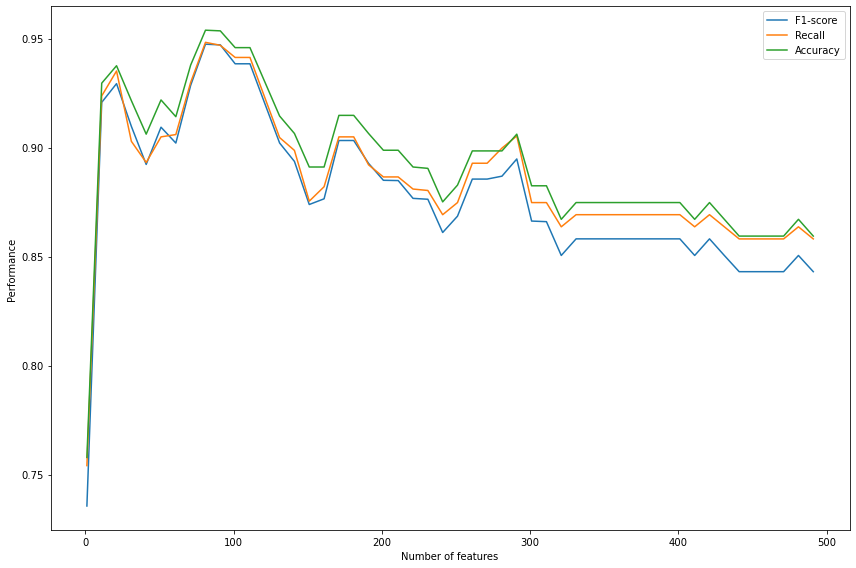

In [6]:
# Calculate the x-axis values
x_values_500 = list(range(1, len(sorted_features_idx) + 1, 10))
if len(sorted_features_idx) % 10 != 0:
    x_values_500.append(len(sorted_features_idx))

import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(12, 8))

# Plot the performance metrics vs. number of features
plt.plot(x_values_500, f1_scores, label='F1-score')
plt.plot(x_values_500, recall_scores, label='Recall')
plt.plot(x_values_500, accuracy_scores, label='Accuracy')
plt.xlabel('Number of features')
plt.ylabel('Performance')
plt.legend()

# Set a tight layout
plt.tight_layout()

# Save the figure in HD (dpi = 300)
plt.savefig(os.path.join(outdir,"performance_vs_features_stacked_500.png"), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Get feature names from the DataFrame
feature_names = np.array(X.columns)

# Map the sorted feature indices to their corresponding feature names
sorted_feature_names = feature_names[sorted_features_idx]


In [7]:
# Assuming your data is in a pandas DataFrame called 'dt'
X = dt[sorted_feature_names[:100].tolist() + ['Label']].drop('Label', axis=1)
y = dt['Label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stacked Generalization (Stacking) with Diverse Base Classifiers
estimators = [
    ('log_reg', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)),
    ('svm', SVC(kernel='linear', class_weight='balanced', random_state=42, probability=True)),
    ('random_forest', RandomForestClassifier(class_weight='balanced', random_state=42))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced', random_state=42), cv=5, n_jobs=-1)
stacking_clf.fit(X_scaled, y)

# Get feature importances from random forest base classifier
rf_clf = stacking_clf.named_estimators_['random_forest']
rf_feature_importances = rf_clf.feature_importances_

# Sort the features by importance
sorted_features_idx = np.argsort(rf_feature_importances)[::-1]

# Initialize performance metrics lists
f1_scores = []
recall_scores = []
accuracy_scores = []

# Iterate over the sorted features and add them in batches of 100
for i in range(1, len(sorted_features_idx) + 1, 2):
    print(i)
    selected_features = sorted_features_idx[:i]
    X_selected = X_scaled[:, selected_features]
    
    # Evaluate the performance using cross-validation
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='f1_macro')
    f1_scores.append(np.mean(scores))
    
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='recall_macro')
    recall_scores.append(np.mean(scores))
    
    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

# Add the last remaining features if the number of features is not divisible by 100
if len(sorted_features_idx) % 2 != 0:
    selected_features = sorted_features_idx
    X_selected = X_scaled[:, selected_features]

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='f1_macro')
    f1_scores.append(np.mean(scores))

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='recall_macro')
    recall_scores.append(np.mean(scores))

    scores = cross_val_score(stacking_clf, X_selected, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99


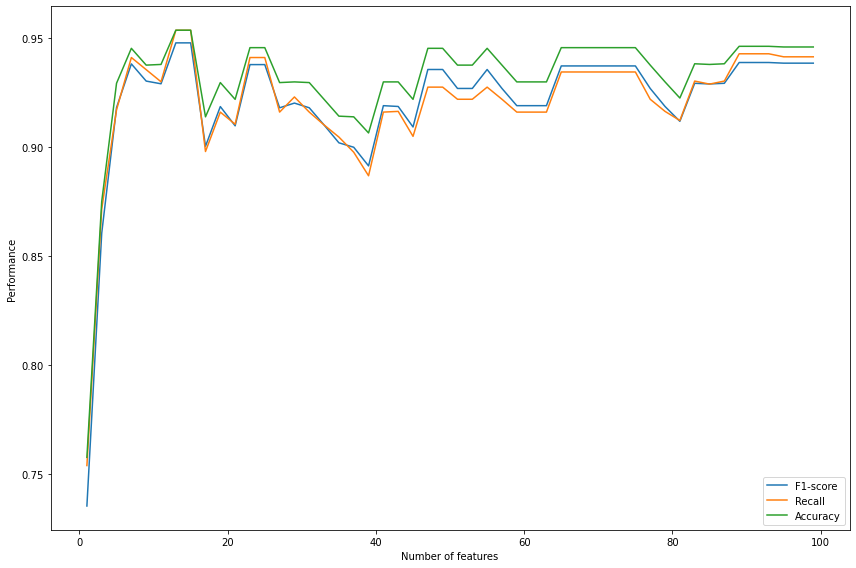

In [8]:
# Calculate the x-axis values
x_values_100 = list(range(1, len(sorted_features_idx) + 1, 2))
if len(sorted_features_idx) % 2 != 0:
    x_values_100.append(len(sorted_features_idx))

import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(12, 8))

# Plot the performance metrics vs. number of features
plt.plot(x_values_100, f1_scores, label='F1-score')
plt.plot(x_values_100, recall_scores, label='Recall')
plt.plot(x_values_100, accuracy_scores, label='Accuracy')
plt.xlabel('Number of features')
plt.ylabel('Performance')
plt.legend()

# Set a tight layout
plt.tight_layout()

# Save the figure in HD (dpi = 300)
plt.savefig(os.path.join(outdir,"performance_vs_features_stacked_100.png"), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Get feature names from the DataFrame
feature_names = np.array(X.columns)

# Map the sorted feature indices to their corresponding feature names
sorted_feature_names = feature_names[sorted_features_idx]

In [9]:
sorted_feature_names[0:12]

array(['LOC90784', 'XRCC6P5', 'LOC101060339', 'FLJ13451', 'MGC22265',
       'FAM207A', 'LOC100294335', 'STON1-GTF2A1L', 'PRLR', 'TRAP2',
       'SERPINC1', 'DUSP23'], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier



import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import classification_report,make_scorer,confusion_matrix


random_state = 23873

def tss(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    tss = (tp/p) - (fp/n)
    return tss

# tss([0, 1, 0, 1], [1, 1, 1, 0])
tss_scorer = make_scorer(tss,greater_is_better=True)

#### hss2

def hss2(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    hss2 = (2 * ((tp*tn) - (fn*fp))) / (p*(fn+tn) + n*(tp+fp))
    return hss2

# hss2([0, 1, 0, 1], [1, 1, 1, 0])
hss2_scorer = make_scorer(hss2,greater_is_better=True)

def modelling_mulitple(x_train, y_train):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    accuracy_means,accuracy_std,precision_means,precision_std,recall_means,recall_std,f1_means,f1_std,tss_mean,tss_std,hss2_mean,hss2_std = [],[],[],[],[],[],[],[],[],[],[],[]

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    scoring = {'accuracy': 'accuracy',
               'precision_macro': 'precision_macro',
               'recall_macro': 'recall_macro',
               'f1_macro': 'f1_macro',
               'tss': tss_scorer,
               'hss2': hss2_scorer}

    for classifier in classifiers:
        print(classifier)
        scores = cross_validate(classifier, x_train, y_train, scoring=scoring, cv=cv)
        accuracy_means.append(scores['test_accuracy'].mean())
        precision_means.append(scores['test_precision_macro'].mean())
        precision_std.append(scores['test_precision_macro'].std())
        recall_means.append(scores['test_recall_macro'].mean())
        recall_std.append(scores['test_recall_macro'].std())
        f1_means.append(scores['test_f1_macro'].mean())
        f1_std.append(scores['test_f1_macro'].std())
        tss_mean.append(scores['test_tss'].mean())
        tss_std.append(scores['test_tss'].std())
        hss2_mean.append(scores['test_hss2'].mean())
        hss2_std.append(scores['test_hss2'].std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'],'Accuracy Mean Score':accuracy_means,
                                                'Precision Mean Score':precision_means, 'Precision std':precision_std,
                                                'Recall Mean Score':recall_means, 'Recall std':recall_std,'F1 Mean Score':f1_means, 'F1 std':f1_std,
                                                'TSS Mean Score':tss_mean, 'TSS std':tss_std, 'HSS2 Mean Score':hss2_mean, 'HSS2 std':hss2_std
                               })

    f, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    

    sns.barplot(x = 'Accuracy Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Cross Validation Scores')
    sns.barplot(x = 'Precision Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Cross Validation Scores')
    sns.barplot(x = 'Recall Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[2]).set(title='Cross Validation Scores')
    sns.barplot(x = 'F1 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[3]).set(title='Cross Validation Scores')
    sns.barplot(x = 'TSS Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[4]).set(title='Cross Validation Scores')
    sns.barplot(x = 'HSS2 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[5]).set(title='Cross Validation Scores')

    accc = ['Accuracy Mean Score', 'Precision Mean Score', 'Recall Mean Score', 'F1 Mean Score', 'TSS Mean Score', 'HSS2 Mean Score']

    for i, acc in enumerate(accc):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=acc, y='Algorithms', data=cv_res, palette="Set2", ax=ax).set(title='Cross Validation Scores')

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Save each figure with a different name
        fig.savefig(os.path.join(outdir, f'{acc}.png'), dpi=300, bbox_inches='tight')
        plt.close(fig)  # Close the figure
    
    return cv_res.sort_values(by='Accuracy Mean Score', ascending=False)

In [11]:
selected_cols = sorted_feature_names[0:12]
from lazypredict.Supervised import LazyClassifier
features = dt[selected_cols.tolist() + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions=clf.fit(x_train, x_test, y_train, y_test)

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [00:01<00:00, 14.33it/s]

[02:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 14.20it/s]


In [12]:
import os

outdir = r'./eval/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
outname = 'models_eval_LazyClassifier.csv'
outdir = r'./eval/stacked'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)    

models.to_csv(fullname,index = False)
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.95,0.94,0.94,0.95,0.10
XGBClassifier,0.95,0.94,0.94,0.95,0.17
RandomForestClassifier,0.95,0.94,0.94,0.95,0.30
ExtraTreesClassifier,0.92,0.90,0.90,0.92,0.27
Perceptron,0.92,0.90,0.90,0.92,0.03
LogisticRegression,0.92,0.90,0.90,0.92,0.04
AdaBoostClassifier,0.92,0.90,0.90,0.92,0.24
BaggingClassifier,0.85,0.87,0.87,0.85,0.07
LabelPropagation,0.87,0.86,0.86,0.87,0.05


LogisticRegression(random_state=23873)
DecisionTreeClassifier(random_state=23873)
SVC(random_state=23873)
GaussianNB()
AdaBoostClassifier(random_state=23873)
RandomForestClassifier(n_estimators=20, random_state=23873)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
[02:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:

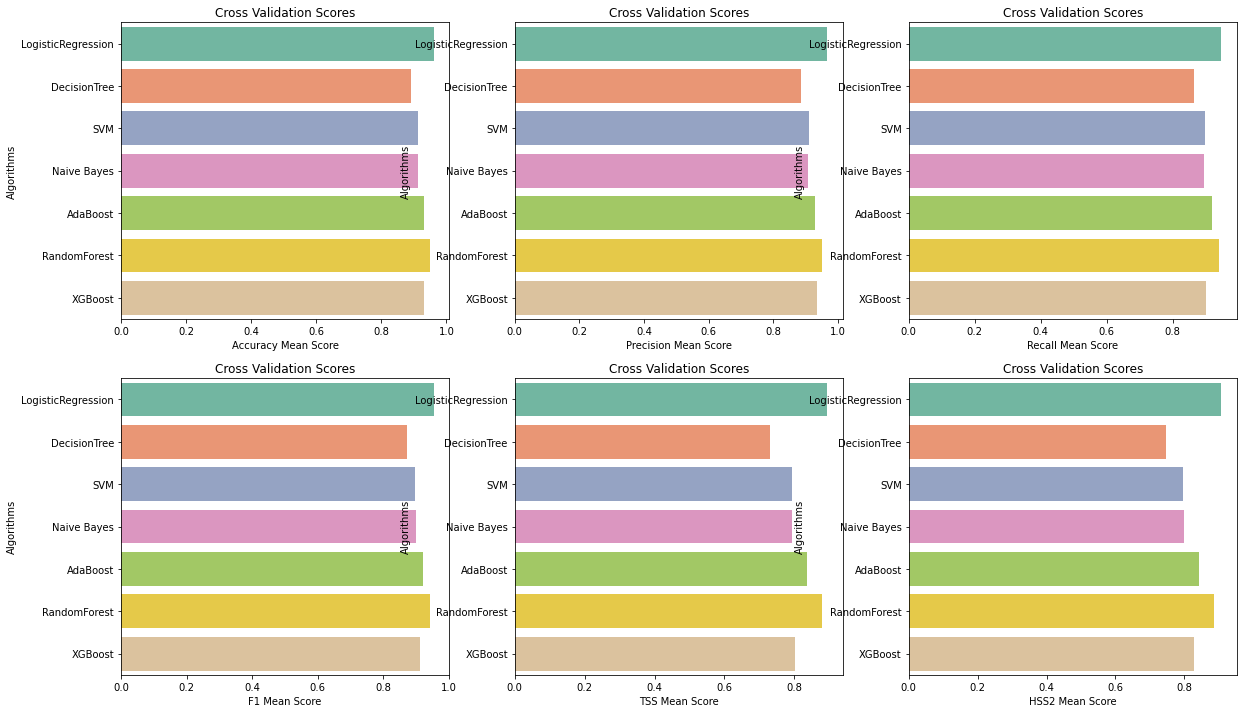

In [13]:
features = dt[selected_cols.tolist() + ['Label']].copy()
target = features.pop('Label')
features = StandardScaler().fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.2)

modelling_mulitple(x_train, y_train).to_csv(os.path.join(outdir, 'model_eval_manual.csv'), index=False)

In [17]:
with open(os.path.join(outdir,'selected features.txt'), 'w') as file:
    file.writelines('\n'.join(selected_cols))

In [31]:
import string
compulsory_parameters =  ['ab_bankaccount','ab_casetype','ab_category','ab_subcategory','caseorigincode','description','ab_confirmfinancialimplication']
data = {
  "ab_bankaccount": "0765071073",
  "ab_casetype": "Complaint",
  "ab_category": "Account Management",
  "ab_subcategory": "Account Migration",
  "ab_confirmfinancialimplication": "No",
  "description": "My account is blocked",
  "caseorigincode": " ",
  "ab_transactionreference": "098WNVI203634Bja",
  "ab_transaction_date": "28/12/2020"
}

print(any(any(char in string.ascii_letters for char in value) for key, value in data.items() if key in compulsory_parameters))
print(all({k: v for k, v in data.items() if k in compulsory_parameters}.values()))
print(all(len(value.strip()) > 0 and any(char.isalnum() for char in value) for key, value in data.items() if key in compulsory_parameters))

True
True
False


In [ ]:
compulsory_parameters =  ['ab_bankaccount','ab_casetype','ab_category','ab_subcategory','caseorigincode','description','ab_confirmfinancialimplication']
data = {
  "ab_bankaccount": "0765071073",
  "ab_casetype": "Complaint",
  "ab_category": "Account Management",
  "ab_subcategory": "Account Migration",
  "ab_confirmfinancialimplication": "No",
  "description": "My account is blocked",
  "caseorigincode": "",
  "ab_transactionreference": "098WNVI203634Bja",
  "ab_transaction_date": "28/12/2020"
}
given this variables, write a condition to check if all values with keys in compulsory_parameters are not empty. i.e has at least one character. only whitespace and only symbols are not valid
